In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
import psycopg2
from pandas.io.json import json_normalize
from classify_campaigns import classify_campaigns

import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import dataframe_image as dfi

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [2]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [3]:
start_dt = '2021-09-11'
end_dt = '2021-10-11'

differences between everything on adcolony

uninstall rates per exchange

In [4]:
def calc_metrics(df, i=0):
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['win_rate'] = 100*df['impressions']/df['bids']
    df['uninstall_rate'] = 100*df['uninstalls']/df['installs']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['bpm'] = 1000*df['bid_price']/df['bids']
    df['cpm'] = 1000*df['cost']/df['impressions']
    
    if i != 0:
        df['cost_sov'] = 100*df['cost']/df.groupby(i)['cost'].transform(sum)
        df['revenue_sov'] = 100*df['revenue']/df.groupby(i)['revenue'].transform(sum)
    else:
        df['cost_sov'] = 100*df['cost']/df['cost'].sum()
        df['revenue_sov'] = 100*df['revenue']/df['revenue'].sum()
        
    df['profit'] = df['revenue']-df['cost']
    df['margin'] = 100*df['profit']/df['revenue']
    return df[['bids','impressions','win_rate','clicks','ctr','installs','ir','uninstall_rate','ipm','bpm','cpm','revenue','revenue_sov','cost','cost_sov','profit','margin']]
def calc_metrics1(df, i=0):
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['win_rate'] = 100*df['impressions']/df['bids']
    df['uninstall_rate'] = 100*df['uninstalls']/df['installs']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['bpm'] = 1000*df['bid_price']/df['bids']
    df['cpm'] = 1000*df['cost']/df['impressions']
    if i != 0:
        df['cost_sov'] = 100*df['cost']/df.groupby(i)['cost'].transform(sum)
        df['revenue_sov'] = 100*df['revenue']/df.groupby(i)['revenue'].transform(sum)
    else:
        df['cost_sov'] = 100*df['cost']/df['cost'].sum()
        df['revenue_sov'] = 100*df['revenue']/df['revenue'].sum()
    df['profit'] = df['revenue']-df['cost']
    df['margin'] = 100*df['profit']/df['revenue']
    return df[['auctions','bids','impressions','win_rate','clicks','ctr','installs','ir','uninstall_rate','ipm','bpm','cpm','revenue','revenue_sov','cost','cost_sov','profit','margin']]

def calc_metrics2(df, i=0):
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['cpm'] = 1000*df['cost']/df['impressions']
    if i != 0:
        df['cost_sov'] = 100*df['cost']/df.groupby(i)['cost'].transform(sum)
        df['revenue_sov'] = 100*df['revenue']/df.groupby(i)['revenue'].transform(sum)
    else:
        df['cost_sov'] = 100*df['cost']/df['cost'].sum()
        df['revenue_sov'] = 100*df['revenue']/df['revenue'].sum()
    df['profit'] = df['revenue']-df['cost']
    df['uninstall_rate'] = 100*df['uninstalls']/df['installs']
    df['margin'] = 100*df['profit']/df['revenue']
    return df[['impressions','clicks','ctr','installs','ir','uninstall_rate','ipm','cpm','revenue','revenue_sov','cost','cost_sov','profit','margin']]

format_map = {'impressions':'{:,.0f}'
             ,'bids':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'revenue':'${:,.0f}'
             ,'cost':'${:,.0f}'
             ,'profit':'${:,.0f}'
             ,'bpm':'${:,.2f}'
             ,'cpm':'${:,.2f}'
             ,'win_rate':'{:,.1f}%'
             ,'ctr':'{:,.0f}%'
             ,'margin':'{:,.0f}%'
             ,'ir':'{:,.1f}%'
             ,'ipm':'{:,.2f}'
             ,'revenue_sov':'{:,.1f}%'
             ,'uninstall_rate':'{:,.0f}%'
             ,'cost_sov':'{:,.1f}%'
             ,'imp_sov':'{:,.1f}%'
             ,'impressions':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'revenue':'${:,.0f}'
             ,'cost':'${:,.0f}'
             ,'cpm':'${:,.2f}'
             ,'ctr':'{:,.1f}%'
             ,'uninstall_rate':'{:,.1f}%'
             ,'ir':'{:,.1f}%'
             ,'ipm':'{:,.2f}'
             ,'revenue_sov':'{:,.1f}%'
             ,'imp_sov_AdColony':'{:,.1f}%'
             ,'impressions_AdColony':'{:,.0f}'
             ,'clicks_AdColony':'{:,.0f}'
             ,'installs_AdColony':'{:,.0f}'
             ,'revenue_AdColony':'${:,.0f}'
             ,'cost_sov_AdColony':'{:,.0f}%'
             ,'margin_AdColony':'{:,.0f}%'
             ,'profit_AdColony':'${:,.0f}'
             ,'cost_AdColony':'${:,.0f}'
             ,'cpm_AdColony':'${:,.2f}'
             ,'ctr_AdColony':'{:,.1f}%'
             ,'ir_AdColony':'{:,.1f}%'
             ,'ipm_AdColony':'{:,.2f}'
             ,'revenue_sov_AdColony':'{:,.1f}%'
             ,'imp_sov_AppLovin':'{:,.1f}%'
             ,'impressions_AppLovin':'{:,.0f}'
             ,'clicks_AppLovin':'{:,.0f}'
             ,'installs_AppLovin':'{:,.0f}'
             ,'revenue_AppLovin':'${:,.0f}'
             ,'cost_sov_AppLovin':'{:,.0f}%'
             ,'margin_AppLovin':'{:,.0f}%'
             ,'profit_AppLovin':'${:,.0f}'
             ,'cost_AppLovin':'${:,.0f}'
             ,'cpm_AppLovin':'${:,.2f}'
             ,'ctr_AppLovin':'{:,.1f}%'
             ,'ir_AppLovin':'{:,.1f}%'
             ,'ipm_AppLovin':'{:,.2f}'
             ,'revenue_sov_AppLovin':'{:,.1f}%'
             ,'imp_sov_Fyber':'{:,.1f}%'
             ,'impressions_Fyber':'{:,.0f}'
             ,'clicks_Fyber':'{:,.0f}'
             ,'installs_Fyber':'{:,.0f}'
             ,'revenue_Fyber':'${:,.0f}'
             ,'cost_sov_Fyber':'{:,.0f}%'
             ,'margin_Fyber':'{:,.0f}%'
             ,'profit_Fyber':'${:,.0f}'
             ,'cost_Fyber':'${:,.0f}'
             ,'cpm_Fyber':'${:,.2f}'
             ,'ctr_Fyber':'{:,.1f}%'
             ,'ir_Fyber':'{:,.1f}%'
             ,'ipm_Fyber':'{:,.2f}'
             ,'revenue_sov_Fyber':'{:,.1f}%'}

In [37]:
byexchange = bigquery_client.query(f"""
select 
    exchange_id
    , 16*sum(if(event_type = 'install',revenue,0)) revenue
    , 100*sum(if(event_type = 'install',revenue,0))/sum(sum(if(event_type = 'install',revenue,0))) over () as revenue_sov
    , 16*sum(if(event_type = 'clear', settlement_price, 0))/1000 cost 
    , 100*sum(if(event_type = 'clear', settlement_price, 0))/sum(sum(if(event_type = 'clear', settlement_price, 0))) over () as cost_sov
from stats.rows1 
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and right(id,1) = '0'
group by 1
order by 2 desc 
""").to_dataframe()
byexchange = pd.merge(byexchange, exchange, on = 'exchange_id')
byexchange = byexchange.groupby('exchange_name')['revenue','revenue_sov','cost','cost_sov'].sum()
byexchange[['exchange_name','revenue','revenue_sov','cost','cost_sov']].style.format('{:,.0f}%').format({'revenue':'${:,,.0f}', 'cost':'${:,,.0f}'})

exchange_id     revenue  revenue_sov          cost   cost_sov  \
0          41.0  3436300.96    45.782151  2.944232e+09  40.854957   
1           1.0  1438753.44    19.168643  1.318483e+09  18.295624   
2          44.0   956329.92    12.741271  1.078257e+09  14.962186   
3           3.0   867561.76    11.558604  8.116767e+08  11.263044   
4           2.0   139078.88     1.852961  1.337663e+08   1.856177   
5          56.0   130318.56     1.736246  1.441783e+08   2.000657   
6          37.0   114028.64     1.519214  1.243603e+08   1.725657   
7          30.0    83709.92     1.115275  1.003149e+08   1.391996   
8          18.0    75360.00     1.004028  7.752765e+07   1.075794   
9           7.0    57251.84     0.762771  6.478863e+07   0.899024   
10         39.0    52293.92     0.696717  6.858874e+07   0.951756   
11         38.0    48644.96     0.648101  6.360309e+07   0.882574   
12          8.0    38399.84     0.511605  2.629350e+07   0.364856   
13         14.0    22374.40     0.298096  3.489578e+07   0.484223   
14         48.0    18208.64     0.242595  2.370803e+07   0.328979   
15         50.0    14731.20     0.196265  1.879978e+06   0.026087   
16         59.0     5575.20     0.074279  1.878894e+07   0.260720   
17         29.0     3573.92     0.047616  4.492427e+06   0.062338   
18         24.0     2964.80     0.039500  8.782184e+06   0.121864   
19         46.0      304.80     0.004061  1.579271e+08   2.191439   
20         55.0        0.00     0.000000  2.550304e+03   0.000035   
21         36.0        0.00     0.000000  8.549600e+02   0.000012   

   exchange_name  
0       AppLovin  
1          Fyber  
2         InMobi  
3          MoPub  
4         Smaato  
5        Algorix  
6          Unity  
7     Chartboost  
8      PubNative  
9        Rubicon  
10         Unity  
11         Unity  
12        Google  
13         Opera  
14      Vertical  
15        MailRu  
16       Samsung  
17     SmartyAds  
18      AdColony  
19  MobilityWare  
20      StartApp  
21        Vungle

In [62]:
byexchange['margin'] = 100*(byexchange.revenue - byexchange.cost)/byexchange.revenue
byexchange.sort_values('revenue', ascending = False, inplace = True)
byexchange[byexchange.revenue > 100].style.format('{:,.0f}%').format({'revenue':'${:,.0f}', 'cost':'${:,.0f}'}).background_gradient(cmap = cm, subset = ['margin'])

In [9]:
query = """
select
    r.date
    , r.ssb_campaign_uuid
    , c.name as campaign_name
    , left(r.ctr_model, LENGTH(r.ctr_model)-4) as model
    , ho.name as hosting_app_name
    , ho.bundle as hosting_bnd
    , sp.name as sponsored_app_name
    , sp.bundle as sponsored_bnd
    , r.exchange_id
    , case when r.exchange_id = 24 then 'AC' else 'RON' end as exchange
    , r.os_version_text
    , r.carrier
    , r.platform
    , r.ad_type
    , r.ad_size
    , r.imp_type
    , r.country
    , r.no_ifa
    , r.ssb_buyer_id
    , count(case when event_type = 'clear' then 1 else NULL end) as impressions
    , count(case when event_type = 'click' then 1 else NULL end) as clicks
    , count(case when event_type = 'install' then 1 else NULL end) as installs
    , sum(if(ui.timestamp is not null,1,0)) uninstalls
    , sum(revenue) as revenue
    , sum(case when event_type = 'clear' then settlement_price else 0 end)/1000 as cost
from stats.rows1 r
join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
join metadata.apps ho
    on r.hosting_app_id = ho.app_id
join metadata.campaigns c
    on r.ssb_campaign_uuid = c.uuid
left join 
(
    select tid, bundle, max(t_created) as timestamp
    from audiences.dt_aud 
    where type = 'uninstall'
    group by 1,2
) ui 
    on r.tid = ui.tid 
    and r.event_type = 'install'
    and ui.bundle = sp.bundle
    and ui.timestamp - r.timestamp <= interval 1 day 
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and right(r.tid,2) = '0{n}'
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
"""

df_list = []
k = 5 # max of 10
for n in list(range(k)):
    print(f'Running query {n+1} of {k}')
    sub_df = bigquery_client.query(query.format(start_dt = start_dt, end_dt = end_dt, n = n)).to_dataframe()
    df_list.append(sub_df)

df = pd.concat(df_list)
del df_list
df = pd.merge(df, imp_type, left_on = 'imp_type', right_on = 'imp_type_id', how = 'left')

Running query 1 of 5
Running query 2 of 5
Running query 3 of 5
Running query 4 of 5
Running query 5 of 5


In [10]:
query = """
select
    date 
    , case when r.exchange_id = 24 then 'AC' else 'RON' end as exchange
    , r.exchange_id
    , r.ad_size
    , r.ad_type
    , left(r.ctr_model, LENGTH(r.ctr_model)-4) as model
    , ho.name as hosting_app_name
    , ho.bundle as hosting_bnd
    , sp.name as sponsored_app_name
    , sp.bundle as sponsored_bnd
    , r.imp_type
    , r.os_version_text
    , r.carrier
    , r.no_ifa 
    , r.country
    , r.ssb_buyer_id 
    , r.platform
    , 32*sum(bid_price)/1000 as bid_price
    , 512*sum(if(event_type = 'auction',1,0))+32*sum(if(event_type = 'bid',1,0)) as auctions
    , 32*sum(if(event_type = 'bid',1,0)) as bids
from stats.auctions_bids r
left join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
left join metadata.apps ho
    on r.hosting_app_id = ho.app_id
left join metadata.campaigns c
    on r.ssb_campaign_uuid = c.uuid
where 
    date(t_created) >= '{start_dt}'
    and date(t_created) <= '{end_dt}'
    and right(r.tid,2) = '0{n}'
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
"""

df_list = []
for n in list(range(k)):
    print(f'Running query {n+1} of {k}')
    sub_df = bigquery_client.query(query.format(start_dt = start_dt, end_dt = end_dt, n = n)).to_dataframe()
    df_list.append(sub_df)

df_auctions_bids = pd.concat(df_list)
del df_list
df_auctions_bids = pd.merge(df_auctions_bids, imp_type, left_on = 'imp_type', right_on = 'imp_type_id', how = 'left')

Running query 1 of 5
Running query 2 of 5
Running query 3 of 5
Running query 4 of 5
Running query 5 of 5


In [11]:
df_auctions_bids[['auctions','bid_price','bids']].sum()

auctions     4.347247e+10
bid_price    5.124433e+06
bids         3.760085e+09
dtype: float64

In [12]:
i = ['platform']
pivot = df.pivot_table(values = ['impressions','clicks','installs','uninstalls','revenue','cost'], index = ['exchange'] + i, aggfunc = np.sum)
pivot2 = df_auctions_bids.pivot_table(values = ['bid_price','bids'], index = i + ['exchange'], aggfunc = np.sum)
pivot = (256/k)*pivot.join(pivot2)

format_pivot = calc_metrics(pivot, 'exchange')
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['win_rate','ctr','ir','ipm','bpm','cpm','revenue_sov','cost_sov','margin'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


In [13]:
i = ['impression type','ad_type']
pivot = df.pivot_table(values = ['impressions','clicks','installs','uninstalls','revenue','cost'], index = ['exchange'] + i, aggfunc = np.sum)
pivot2 = df_auctions_bids.pivot_table(values = ['bid_price','bids'], index = i + ['exchange'], aggfunc = np.sum)
pivot = (256/k)*pivot.join(pivot2)
format_pivot = calc_metrics(pivot, 'exchange')
format_pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['win_rate','ctr','ir','ipm','bpm','cpm','revenue_sov','cost_sov','margin'])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))


# pub overlap

In [5]:
query = """
select 
    REPLACE(JSON_EXTRACT(ab.raw_request, '$.app.bundle'),'"','') as hosting_bnd
    , max(ab.app_name) as hosting_app_name
    , exchange_id
    , ad_size
    , ad_type
    , imp_type
    , ab.ssb_buyer_id 
    , ab.ssb_campaign_uuid
    , c.name as campaign_name
    , 512*sum(if(event_type = 'auction',1,0)) + 32*sum(if(event_type = 'bid',1,0)) auctions
    , 32*sum(if(event_type = 'bid',1,0)) bids
    , 32*sum(if(event_type = 'bid',bid_price,0))/1000 bid_price
    , 0 as impressions
    , 0 as clicks
    , 0 as installs
    , 0 as uninstalls
    , 0 as revenue
    , 0 as cost 
from stats.auctions_bids ab 
left join metadata.campaigns c 
    on ab.ssb_campaign_uuid = c.uuid
where 
    date(ab.t_created) >= '{start_dt}'
    and date(ab.t_created) <= '{end_dt}'
    and exchange_id in (1,41,24)
group by 1,3,4,5,6,7,8,9

union all

select
    ho.bundle as hosting_bnd
    , ho.name as hosting_app_name
    , exchange_id
    , ad_size
    , ad_type
    , imp_type
    , r.ssb_buyer_id 
    , r.ssb_campaign_uuid
    , c.name as campaign_name
    , 0 as auctions
    , 0 as bids
    , 0 as bid_price
    , 4*sum(if(event_type = 'clear',1,0)) impressions
    , 4*sum(if(event_type = 'click',1,0)) clicks
    , 4*sum(if(event_type = 'install',1,0)) installs
    , 4*sum(if(ui.timestamp is not null,1,0)) uninstalls
    , 4*sum(if(event_type = 'install',revenue,0)) revenue
    , 4*sum(if(event_type = 'clear',settlement_price,0))/1000 cost 
from stats.rows1 r
left join metadata.campaigns c 
    on r.ssb_campaign_uuid = c.uuid
left join metadata.apps ho
    on r.hosting_app_id = ho.app_id
left join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
left join 
(
    select tid, bundle, max(t_created) as timestamp
    from audiences.dt_aud 
    where type = 'uninstall'
    group by 1,2
) ui 
    on r.tid = ui.tid 
    and r.event_type = 'install'
    and ui.bundle = sp.bundle
    and ui.timestamp - r.timestamp <= interval 1 day 
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and r.exchange_id in (1,41,24)
    and right(r.id,1) in ('0','1','2','3')
group by 1,2,3,4,5,6,7,8,9
"""
df_pub_overlap = bigquery_client.query(query.format(start_dt = start_dt, end_dt = end_dt)).to_dataframe()

df_pub_overlap = pd.merge(df_pub_overlap, imp_type, left_on = 'imp_type', right_on = 'imp_type_id', how = 'left')
df_pub_overlap = pd.merge(df_pub_overlap, exchange, on = 'exchange_id', how = 'left')

In [6]:
df_pub_overlap['experience_type'] = df_pub_overlap.apply(lambda x:classify_campaigns(x), axis = 1)
df_pub_overlap['STI_link'] = np.where(df_pub_overlap.experience_type.isin([1,2,3,5,6]), True, False)

In [44]:
pivot = df_pub_overlap.pivot_table(values = ['bids','bid_price','impressions','clicks','installs','uninstalls','revenue','cost'], index = ['exchange_name','STI_link'], aggfunc = np.sum)
pivot = calc_metrics(pivot, 'exchange_name')
pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['win_rate','ctr','ir','uninstall_rate','ipm','bpm','cpm','revenue_sov','cost_sov','margin'])

In [39]:
pivot = df_pub_overlap.pivot_table(values = ['bids','bid_price','impressions','clicks','installs','uninstalls','revenue','cost'], index = ['exchange_name','impression type','ad_type'], aggfunc = np.sum)
pivot = calc_metrics(pivot[pivot.impressions > 5000], 'exchange_name')
pivot.style.format(format_map).background_gradient(cmap=cm, subset = ['win_rate','ctr','ir','uninstall_rate','ipm','bpm','cpm','revenue_sov','cost_sov','margin'])

<ipython-input-4-ff08795eee89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ctr'] = 100*df['clicks']/df['impressions']
<ipython-input-4-ff08795eee89>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ir'] = 100*df['installs']/df['clicks']
<ipython-input-4-ff08795eee89>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [45]:
pivot = df_pub_overlap.pivot_table(values = ['bids','bid_price','impressions','clicks','installs','uninstalls','revenue','cost'], index = ['STI_link','impression type','ad_type','exchange_name'], aggfunc = np.sum)
pivot = calc_metrics(pivot[pivot.impressions > 1000], 'exchange_name')
filters = pivot.index.get_level_values(1).isin(['video','rewarded video'])
pivot[filters].style.format(format_map).background_gradient(cmap=cm, subset = ['win_rate','ctr','ir','uninstall_rate','ipm','bpm','cpm','revenue_sov','cost_sov','margin'])


<ipython-input-4-ff08795eee89>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ctr'] = 100*df['clicks']/df['impressions']
<ipython-input-4-ff08795eee89>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ir'] = 100*df['installs']/df['clicks']
<ipython-input-4-ff08795eee89>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [10]:
df_pub_overlap[(df_pub_overlap.auctions > 0) ]

hosting_bnd  \
1573580  athena.studio.colorisland.pixel.art.puzzle   
1573581               com.bigcake.android.dicemerge   
1573582               sudoku.puzzle.free.game.brain   
1573583                          com.playstrom.dop2   
1573584            com.wordgame.newcross.android.en   
...                                             ...   
3508151                 com.tile.match.connect.game   
3508152           com.gamemavericks.farmingbeetroot   
3508153                         com.mobirate.bigrig   
3508154                  com.limongames.supersoccer   
3508155                   com.cocoplay.sweet.bakery   

                                        hosting_app_name  exchange_id  \
1573580                          Color Island: Pixel Art           41   
1573581                                             None           41   
1573582  Sudoku - Sudoku puzzle, Brain game, Number game           41   
1573583                           DOP 2: Delete One Part           41   
1573584                                       Word Craze           41   
...                                                  ...          ...   
3508151                                      Tile Master           24   
3508152                           euro farming: beetroot           41   
3508153                                   Big Rig Racing           41   
3508154                                     Super Soccer           41   
3508155                                      sweetbakery           41   

         ad_size ad_type  imp_type  ssb_buyer_id  \
1573580   320x50  banner       1.0        2861.0   
1573581     None   inter      16.0           NaN   
1573582   320x50  banner       1.0        1343.0   
1573583   320x50  banner       1.0        3549.0   
1573584   320x50  banner       1.0        3549.0   
...          ...     ...       ...           ...   
3508151  320x480   inter       2.0        3549.0   
3508152  320x480   inter       2.0        3549.0   
3508153  320x480   inter      16.0        3549.0   
3508154  480x320   inter       2.0        3353.0   
3508155  320x480   inter       1.0        3549.0   

                        ssb_campaign_uuid  \
1573580  e39d31112404d569cdb3b91a0d3cbac0   
1573581                              None   
1573582  a5b3abf76574e1341589891def860937   
1573583  70751479c8bfbdd722d73afdf36e0542   
1573584  fb9d2fdb882ea110d77ab74ffc35730a   
...                                   ...   
3508151  d8be47c87ebd5047c552f92421103f1a   
3508152  d586c5c03639077d51d5931197bdbbb4   
3508153  6511f9bd6121500fa4082bc1209ad8d1   
3508154  2c7f45e858f5529b3c1d70f858c38df2   
3508155  fb9d2fdb882ea110d77ab74ffc35730a   

                                        campaign_name   auctions  ...  clicks  \
1573580  [g|Braindoku][p|android][id|12786]_US_banner      34848  ...       0   
1573581                                          None  414734336  ...       0   
1573582                               Ualá_AR_Android     891296  ...       0   
1573583                  Android-Twitter-Twitter-US-4     772320  ...       0   
1573584        Android-Amply Media-Breaking News-US-2     335712  ...       0   
...                                               ...        ...  ...     ...   
3508151       SmartNews_Tracfone_SingleTap_All_CPI_NA        128  ...       0   
3508152                   Android-Bigo-Bigo Live-US-2         32  ...       0   
3508153        Android-Grupo Coppel-Coppel-MX-2-Blend         64  ...       0   
3508154                 Solitaire - Android - US - ST         64  ...       0   
3508155        Android-Amply Media-Breaking News-US-2         32  ...       0   

         installs  uninstalls  revenue  cost  impression type  imp_type_id  \
1573580         0           0      0.0   0.0          display          1.0   
1573581         0           0      0.0   0.0   rewarded video         16.0   
1573582         0           0      0.0   0.0          display          1.0   
1573583         0           0      0.0   0.0       

In [11]:
df_pub_overlap[['auctions','bids','impressions','clicks','installs','revenue','cost']].sum()

auctions       9.708875e+11
bids           2.417581e+10
impressions    1.661951e+09
clicks         6.950395e+07
installs       5.147112e+06
revenue        5.309048e+06
cost           5.092147e+06
dtype: float64

In [12]:
pub_dict = {}
for x in ['AppLovin','Fyber','AdColony']:
    filters = (df_pub_overlap.exchange_name == x) & (df_pub_overlap.imp_type.isin([2,16])) 
    pivot = df_pub_overlap[filters].pivot_table(values = ['auctions','bids','bid_price','impressions','clicks','installs','uninstalls','revenue','cost'], index = ['hosting_bnd'], aggfunc = np.sum)
    pub_dict[x] = calc_metrics1(pivot)
    
adcolony_applovin = pub_dict['AppLovin'].join(pub_dict['AdColony'], how = 'outer', lsuffix = '_AppLovin', rsuffix = '_AdColony')
adcolony_fyber = pub_dict['Fyber'].join(pub_dict['AdColony'], how = 'outer', lsuffix = '_Fyber', rsuffix = '_AdColony')
fyber_applovin = pub_dict['AppLovin'].join(pub_dict['Fyber'], how = 'outer', lsuffix = '_AppLovin', rsuffix = '_Fyber')
fyber_bypub = pub_dict['Fyber']
fyber_bypub.columns = [f'{x}_Fyber' for x in fyber_bypub.columns]
adcolony_applovin_fyber = adcolony_applovin.join(pub_dict['Fyber'], how = 'outer', rsuffix = '_Fyber')

In [13]:
pub_dict = {}
for x in ['AppLovin','Fyber','AdColony']:
    filters = (df_pub_overlap.exchange_name == x) 
    pivot = df_pub_overlap[filters].pivot_table(values = ['auctions','bids','bid_price','impressions','clicks','installs','uninstalls','revenue','cost'], index = ['hosting_bnd'], aggfunc = np.sum)
    pub_dict[x] = calc_metrics1(pivot)
    
adcolony_applovin_all = pub_dict['AppLovin'].join(pub_dict['AdColony'], how = 'outer', lsuffix = '_AppLovin', rsuffix = '_AdColony')
adcolony_fyber_all = pub_dict['Fyber'].join(pub_dict['AdColony'], how = 'outer', lsuffix = '_Fyber', rsuffix = '_AdColony')
fyber_applovin_all = pub_dict['AppLovin'].join(pub_dict['Fyber'], how = 'outer', lsuffix = '_AppLovin', rsuffix = '_Fyber')

In [14]:
type_dict = {}
for x in ['AppLovin','Fyber','AdColony']:
    filters = (df_pub_overlap.exchange_name == x) & (df_pub_overlap.imp_type.isin([2,16])) 
    pivot = df_pub_overlap[filters].pivot_table(values = ['auctions','bids','bid_price','impressions','clicks','installs','uninstalls','revenue','cost'], index = ['impression type'], aggfunc = np.sum)
    type_dict[x] = calc_metrics1(pivot)
    
adcolony_applovin_type = type_dict['AppLovin'].join(type_dict['AdColony'], how = 'outer', lsuffix = '_AppLovin', rsuffix = '_AdColony')


In [15]:
def define_imp_overlap(x):
    if x.impressions_AppLovin > 0 and (pd.isna(x.impressions_AdColony) or x.impressions_AdColony == 0):
        return 'AppLovin only'
    elif (x.impressions_AppLovin == 0 or pd.isna(x.impressions_AppLovin)) and x.impressions_AdColony > 0:
        return 'AdColony only'
    elif x.impressions_AppLovin > 0 and x.impressions_AdColony > 0:
        return 'Both'
    else:
        return 'None'
adcolony_applovin['imp_overlap'] = adcolony_applovin.apply(lambda x:define_imp_overlap(x), axis = 1)

pivot = adcolony_applovin.reset_index().pivot_table(values = ['hosting_bnd','cost_AppLovin','cost_AdColony','impressions_AppLovin','impressions_AdColony']
                             , index = 'imp_overlap'
                             , aggfunc = {'hosting_bnd':lambda x:len(x.unique())
                                          
                                          ,'cost_AppLovin':np.sum
                                          ,'cost_AdColony':np.sum
                                          ,'impressions_AppLovin':np.sum
                                          ,'impressions_AdColony':np.sum
                                         })
print('Videos only, imp overlap')
pivot.style.format('{:,.0f}').format({'cost_AdColony':'${:,.0f}','cost_AppLovin':'${:,.0f}'})

Videos only, imp overlap


In [16]:
def define_bid_overlap(x):
    if x.bids_AppLovin > 0 and (pd.isna(x.bids_AdColony) or x.bids_AdColony == 0):
        return 'AppLovin only'
    elif (x.bids_AppLovin == 0 or pd.isna(x.bids_AppLovin)) and x.bids_AdColony > 0:
        return 'AdColony only'
    elif x.bids_AppLovin > 0 and x.bids_AdColony > 0:
        return 'Both'
    else:
        return 'None'
adcolony_applovin['bid_overlap'] = adcolony_applovin.apply(lambda x:define_bid_overlap(x), axis = 1)

pivot = adcolony_applovin.reset_index().pivot_table(values = ['hosting_bnd','cost_AppLovin','cost_AdColony','bids_AppLovin','bids_AdColony','impressions_AppLovin','impressions_AdColony']
                             , index = 'bid_overlap'
                             , aggfunc = {'hosting_bnd':lambda x:len(x.unique())
                                          ,'cost_AppLovin':np.sum
                                          ,'cost_AdColony':np.sum
                                          ,'bids_AppLovin':np.sum
                                          ,'bids_AdColony':np.sum
                                          ,'impressions_AppLovin':np.sum
                                          ,'impressions_AdColony':np.sum
                                         })
print('Videos only, bid overlap')
pivot.style.format('{:,.0f}').format({'cost_AdColony':'${:,.0f}','cost_AppLovin':'${:,.0f}'})

Videos only, bid overlap


In [17]:
adcolony_applovin[adcolony_applovin.bid_overlap == 'AppLovin only'].to_csv(f'~/Downloads/AppLovin_exclusive_no_Adcolony_{start_dt}_{end_dt}.csv')

In [18]:
adcolony_applovin_all['imp_overlap'] = adcolony_applovin_all.apply(lambda x:define_imp_overlap(x), axis = 1)

pivot = adcolony_applovin_all.reset_index().pivot_table(values = ['hosting_bnd','cost_AppLovin','cost_AdColony','impressions_AppLovin','impressions_AdColony']
                             , index = 'imp_overlap'
                             , aggfunc = {'hosting_bnd':lambda x:len(x.unique())
                                          ,'cost_AppLovin':np.sum
                                          ,'cost_AdColony':np.sum
                                          ,'impressions_AppLovin':np.sum
                                          ,'impressions_AdColony':np.sum
                                         })
print('all ad types')
pivot.style.format('{:,.0f}').format({'cost_AdColony':'${:,.0f}','cost_AppLovin':'${:,.0f}'})

all ad types


In [19]:
adcolony_applovin.sort_values(['cost_AppLovin','cost_AdColony'], ascending = False, inplace = True)
adcolony_applovin[adcolony_applovin.bid_overlap == 'Both'].to_csv(f'~/Downloads/adcolony_applovin_overlap_bypub_{start_dt}_{end_dt}.csv')
adcolony_applovin[adcolony_applovin.bid_overlap == 'Both'].head(30).style.format(format_map).background_gradient(cmap=cm, subset = ['ctr_AppLovin','ir_AppLovin','ipm_AppLovin','ctr_AdColony','ir_AdColony','ipm_AdColony'])


(0.0, 125.0)

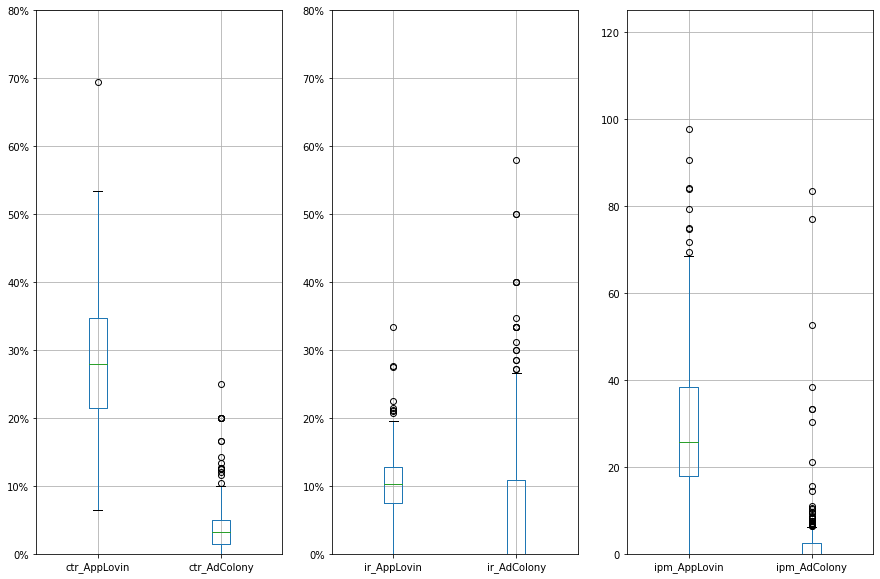

In [20]:
fig, ax = plt.subplots(1,3,figsize = (15,10))
adcolony_applovin.loc[(adcolony_applovin.bid_overlap == 'Both') & ((adcolony_applovin.cost_sov_AppLovin > .1)|(adcolony_applovin.cost_sov_AdColony > .1)), ['ctr_AppLovin','ctr_AdColony']].boxplot(ax = ax[0])
ax[0].set_ylim(0,80)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
adcolony_applovin.loc[(adcolony_applovin.bid_overlap == 'Both') & ((adcolony_applovin.cost_sov_AppLovin > .1)|(adcolony_applovin.cost_sov_AdColony > .1)), ['ir_AppLovin','ir_AdColony']].boxplot(ax = ax[1])
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[1].set_ylim(0,80)
adcolony_applovin.loc[(adcolony_applovin.bid_overlap == 'Both') & ((adcolony_applovin.cost_sov_AppLovin > .1)|(adcolony_applovin.cost_sov_AdColony > .1)), ['ipm_AppLovin','ipm_AdColony']].boxplot(ax = ax[2])
ax[2].set_ylim(0,125)


In [21]:
type_pivot = pd.concat([type_dict['AppLovin'], type_dict['Fyber'], type_dict['AdColony']], keys = ['AppLovin','Fyber','AdColony'], names = ['exchange'])
type_pivot[type_pivot.columns[1:]].style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','ipm','cpm','revenue_sov','cost_sov','margin'])

In [22]:
pivot = df_pub_overlap.pivot_table(values = ['impressions','cost'], index = ['exchange_name','impression type'], aggfunc = np.sum)
pivot['cost_sov'] = 100*pivot['cost']/pivot.groupby('exchange_name')['cost'].transform(sum)
pivot['impressions_sov'] = 100*pivot['impressions']/pivot.groupby('exchange_name')['impressions'].transform(sum)
pivot.style.format('{:,.0f}%').format({'cost':'${:,.0f}', 'impressions':'{:,.0f}'}).background_gradient(cmap=cm, subset = ['cost_sov','impressions_sov'])

In [23]:
def define_imp_overlap(x):
    if x.impressions_AppLovin > 0 and (pd.isna(x.impressions_Fyber) or x.impressions_Fyber == 0):
        return 'AppLovin only'
    elif (x.impressions_AppLovin == 0 or pd.isna(x.impressions_AppLovin)) and x.impressions_Fyber > 0:
        return 'Fyber only'
    elif x.impressions_AppLovin > 0 and x.impressions_Fyber > 0:
        return 'Both'
    else:
        return 'None'
fyber_applovin_all['imp_overlap'] = fyber_applovin_all.apply(lambda x:define_imp_overlap(x), axis = 1)

pivot = fyber_applovin_all.reset_index().pivot_table(values = ['hosting_bnd','cost_AppLovin','cost_Fyber','impressions_AppLovin','impressions_Fyber']
                             , index = 'imp_overlap'
                             , aggfunc = {'hosting_bnd':lambda x:len(x.unique())
                                          ,'cost_AppLovin':np.sum
                                          ,'cost_Fyber':np.sum
                                          ,'impressions_AppLovin':np.sum
                                          ,'impressions_Fyber':np.sum
                                         })
print('All types')
pivot.style.format('{:,.0f}').format({'cost_Fyber':'${:,.0f}','cost_AppLovin':'${:,.0f}'})

All types


Interestingly, AppLovin has more overlap with AdColony than with Fyber, even though AdColony has so much less spend.

In [24]:
def define_imp_overlap(x):
    if x.impressions_AdColony > 0 and (pd.isna(x.impressions_Fyber) or x.impressions_Fyber == 0):
        return 'AdColony only'
    elif (x.impressions_AdColony == 0 or pd.isna(x.impressions_AdColony)) and x.impressions_Fyber > 0:
        return 'Fyber only'
    elif x.impressions_AdColony > 0 and x.impressions_Fyber > 0:
        return 'Both'
    else:
        return 'None'
adcolony_fyber_all['imp_overlap'] = adcolony_fyber_all.apply(lambda x:define_imp_overlap(x), axis = 1)

pivot = adcolony_fyber_all.reset_index().pivot_table(values = ['hosting_bnd','cost_AdColony','cost_Fyber','impressions_AdColony','impressions_Fyber']
                             , index = 'imp_overlap'
                             , aggfunc = {'hosting_bnd':lambda x:len(x.unique())
                                          ,'cost_AdColony':np.sum
                                          ,'cost_Fyber':np.sum
                                          ,'impressions_AdColony':np.sum
                                          ,'impressions_Fyber':np.sum
                                         })
print('All types')
pivot.style.format('{:,.0f}').format({'cost_Fyber':'${:,.0f}','cost_AdColony':'${:,.0f}'})

All types


In [25]:
def define_bid_overlap(x):
    if x.bids_AdColony > 0 and (pd.isna(x.bids_Fyber) or x.bids_Fyber == 0):
        return 'AdColony only'
    elif (x.bids_AdColony == 0 or pd.isna(x.bids_AdColony)) and x.bids_Fyber > 0:
        return 'Fyber only'
    elif x.bids_AdColony > 0 and x.bids_Fyber > 0:
        return 'Both'
    else:
        return 'None'
adcolony_fyber_all['bid_overlap'] = adcolony_fyber_all.apply(lambda x:define_bid_overlap(x), axis = 1)

pivot = adcolony_fyber_all.reset_index().pivot_table(values = ['hosting_bnd','cost_AdColony','cost_Fyber','impressions_AdColony','impressions_Fyber']
                             , index = 'bid_overlap'
                             , aggfunc = {'hosting_bnd':lambda x:len(x.unique())
                                          ,'cost_AdColony':np.sum
                                          ,'cost_Fyber':np.sum
                                          ,'impressions_AdColony':np.sum
                                          ,'impressions_Fyber':np.sum
                                         })
print('All types')
pivot.style.format('{:,.0f}').format({'cost_Fyber':'${:,.0f}','cost_AdColony':'${:,.0f}'})

All types


# Triple join

In [26]:
def define_imp_overlap(x):
    if x.impressions_AppLovin > 0 and (pd.isna(x.impressions_AdColony) or x.impressions_AdColony == 0) and (pd.isna(x.impressions_Fyber) or x.impressions_Fyber == 0):
        return 'AppLovin only'
    elif (x.impressions_AppLovin == 0 or pd.isna(x.impressions_AppLovin)) and x.impressions_AdColony > 0 and (pd.isna(x.impressions_Fyber) or x.impressions_Fyber == 0):
        return 'AdColony only'
    elif (x.impressions_AppLovin == 0 or pd.isna(x.impressions_AppLovin)) and (pd.isna(x.impressions_AdColony) or x.impressions_AdColony == 0) and x.impressions_Fyber > 0:
        return 'Fyber only'
    elif x.impressions_AppLovin > 0 and (pd.isna(x.impressions_AdColony) or x.impressions_AdColony == 0) and x.impressions_Fyber > 0:
        return 'AppLovin/Fyber'
    elif x.impressions_AppLovin > 0 and x.impressions_AdColony > 0 and (pd.isna(x.impressions_Fyber) or x.impressions_Fyber == 0):
        return 'AppLovin/AdColony'
    elif (x.impressions_AppLovin == 0 or pd.isna(x.impressions_AppLovin)) and x.impressions_AdColony > 0 and x.impressions_Fyber > 0:
        return 'Fyber/AdColony'
    elif x.impressions_AppLovin > 0 and x.impressions_AdColony > 0 and x.impressions_Fyber > 0:
        return 'Fyber/AdColony/AppLovin'
    else:
        return 'None'
adcolony_applovin_fyber['imp_overlap'] = adcolony_applovin_fyber.apply(lambda x:define_imp_overlap(x), axis = 1)

In [27]:
def define_bid_overlap(x):
    if (x.bids_AppLovin > 0 or x.auctions_AppLovin > 0) and (pd.isna(x.bids_AdColony) or x.bids_AdColony == 0) and (pd.isna(x.auctions_AdColony) or x.auctions_AdColony == 0) and (pd.isna(x.bids_Fyber) or x.bids_Fyber == 0) and (pd.isna(x.auctions_Fyber) or x.auctions_Fyber == 0):
        return 'AppLovin only'
    elif (x.bids_AppLovin == 0 or pd.isna(x.bids_AppLovin)) and (x.auctions_AdColony > 0 or x.bids_AdColony > 0) and (pd.isna(x.bids_Fyber) or x.bids_Fyber == 0) and (pd.isna(x.auctions_Fyber) or x.auctions_Fyber == 0):
        return 'AdColony only'
    elif (x.bids_AppLovin == 0 or pd.isna(x.bids_AppLovin)) and (pd.isna(x.bids_AdColony) or x.bids_AdColony == 0) and (pd.isna(x.auctions_AdColony) or x.auctions_AdColony == 0) and (x.bids_Fyber > 0 or x.auctions_Fyber > 0):
        return 'Fyber only'
    elif (x.bids_AppLovin > 0 or x.auctions_AppLovin > 0) and (pd.isna(x.bids_AdColony) or x.bids_AdColony == 0) and (pd.isna(x.auctions_AdColony) or x.auctions_AdColony == 0) and (x.bids_Fyber > 0 or x.auctions_Fyber > 0):
        return 'AppLovin/Fyber'
    elif (x.bids_AppLovin > 0 or x.auctions_AppLovin > 0) and (x.auctions_AdColony > 0 or x.bids_AdColony > 0) and (pd.isna(x.bids_Fyber) or x.bids_Fyber == 0) and (pd.isna(x.auctions_Fyber) or x.auctions_Fyber == 0):
        return 'AppLovin/AdColony'
    elif (x.bids_AppLovin == 0 or pd.isna(x.bids_AppLovin)) and (x.auctions_AdColony > 0 or x.bids_AdColony > 0) and (x.bids_Fyber > 0 or x.auctions_Fyber > 0):
        return 'Fyber/AdColony'
    elif (x.bids_AppLovin > 0 or x.auctions_AppLovin > 0) and (x.auctions_AdColony > 0 or x.bids_AdColony > 0) and (x.bids_Fyber > 0 or x.auctions_Fyber > 0):
        return 'Fyber/AdColony/AppLovin'
    else:
        return 'None'
adcolony_applovin_fyber['bid_overlap'] = adcolony_applovin_fyber.apply(lambda x:define_bid_overlap(x), axis = 1)

pivot = adcolony_applovin_fyber.reset_index().pivot_table(values = ['hosting_bnd','cost_AppLovin','cost_AdColony','cost_Fyber','impressions_AppLovin','impressions_AdColony','impressions_Fyber'
                                                                   ,'revenue_AppLovin','revenue_AdColony','revenue_Fyber','installs_AppLovin','installs_AdColony','installs_Fyber']
                             , index = 'bid_overlap'
                             , aggfunc = {'hosting_bnd':lambda x:len(x.unique())
                                          ,'cost_AppLovin':np.sum
                                          ,'cost_AdColony':np.sum
                                          ,'cost_Fyber':np.sum
                                          ,'impressions_AppLovin':np.sum
                                          ,'impressions_AdColony':np.sum
                                          ,'impressions_Fyber':np.sum
                                          ,'revenue_AppLovin':np.sum
                                          ,'revenue_AdColony':np.sum
                                          ,'revenue_Fyber':np.sum
                                          ,'installs_AppLovin':np.sum
                                          ,'installs_AdColony':np.sum
                                          ,'installs_Fyber':np.sum
                                         })
cols = ['cost_AppLovin','cost_Fyber','cost_AdColony','revenue_AppLovin','revenue_Fyber','revenue_AdColony','hosting_bnd','impressions_AppLovin','impressions_Fyber','impressions_AdColony']
pivot[cols].style.format('{:,.0f}').format({'cost_AdColony':'${:,.0f}','cost_Fyber':'${:,.0f}','cost_AppLovin':'${:,.0f}','revenue_AdColony':'${:,.0f}','revenue_Fyber':'${:,.0f}','revenue_AppLovin':'${:,.0f}'}).background_gradient(cmap=cm)


In [28]:
adcolony_applovin_fyber.loc[adcolony_applovin_fyber.bid_overlap == 'None'].transpose()

hosting_bnd             100040582      100042611     1091505255  \
auctions_AppLovin             0.0            0.0            0.0   
bids_AppLovin                 0.0            0.0            0.0   
impressions_AppLovin          0.0           16.0            4.0   
win_rate_AppLovin             NaN            inf            inf   
clicks_AppLovin               4.0            0.0            0.0   
ctr_AppLovin                  inf            0.0            0.0   
installs_AppLovin             0.0            0.0            0.0   
ir_AppLovin                   0.0            NaN            NaN   
uninstall_rate_AppLovin       NaN            NaN            NaN   
ipm_AppLovin                  NaN            0.0            0.0   
bpm_AppLovin                  NaN            NaN            NaN   
cpm_AppLovin                  NaN        1.60925          0.962   
revenue_AppLovin              0.0            0.0            0.0   
revenue_sov_AppLovin          0.0            0.0            0.0   
cost_AppLovin                 0.0       0.025748       0.003848   
cost_sov_AppLovin             0.0       0.000001            0.0   
profit_AppLovin               0.0      -0.025748      -0.003848   
margin_AppLovin               NaN           -inf           -inf   
auctions_AdColony             NaN            NaN            NaN   
bids_AdColony                 NaN            NaN            NaN   
impressions_AdColony          NaN            NaN            NaN   
win_rate_AdColony             NaN            NaN            NaN   
clicks_AdColony               NaN            NaN            NaN   
ctr_AdColony                  NaN            NaN            NaN   
installs_AdColony             NaN            NaN            NaN   
ir_AdColony                   NaN            NaN            NaN   
uninstall_rate_AdColony       NaN            NaN            NaN   
ipm_AdColony                  NaN            NaN            NaN   
bpm_AdColony                  NaN            NaN            NaN   
cpm_AdColony                  NaN            NaN            NaN   
revenue_AdColony              NaN            NaN            NaN   
revenue_sov_AdColony          NaN            NaN            NaN   
cost_AdColony                 NaN            NaN            NaN   
cost_sov_AdColony             NaN            NaN            NaN   
profit_AdColony               NaN            NaN            NaN   
margin_AdColony               NaN            NaN            NaN   
auctions_Fyber                NaN            NaN            NaN   
bids_Fyber                    NaN            NaN            NaN   
impressions_Fyber             NaN            NaN            NaN   
win_rate_Fyber                NaN            NaN            NaN   
clicks_Fyber                  NaN            NaN            NaN   
ctr_Fyber                     NaN            NaN            NaN   
installs_Fyber                NaN            NaN            NaN   
ir_Fyber                      NaN            NaN            NaN   
uninstall_rate_Fyber          NaN            NaN            NaN   
ipm_Fyber                     NaN            NaN            NaN   
bpm_Fyber                     NaN            NaN            NaN   
cpm_Fyber                     NaN            NaN            NaN   
revenue_Fyber                 NaN            NaN            NaN   
revenue_sov_Fyber             NaN            NaN            NaN   
cost_Fyber                    NaN            NaN            NaN   
cost_sov_Fyber                NaN            NaN            NaN   
profit_Fyber                  NaN            NaN            NaN   
margin_Fyber                  NaN            NaN            NaN   
imp_overlap                  None  AppLovin only  AppLovin only   
bid_overlap                  None           None           None   

hosting_bnd                 1160650256     1172774167 1245376733  1317268734  \
auctions_AppLovin                  0.0            0.0        0.0         NaN   
bids_AppLovin       

In [29]:
bnd_to_name_map = df_pub_overlap.groupby('hosting_bnd')['hosting_app_name'].first().to_frame().iloc[1:]

In [30]:
pivot = adcolony_applovin_fyber[adcolony_applovin_fyber.imp_overlap == 'Fyber/AdColony/AppLovin']
pivot = pivot.join(bnd_to_name_map)
pivot.reset_index().set_index(['hosting_bnd','hosting_app_name']).to_csv(f'~/Downloads/AdColony_AppLovin_Fyber_overlap_bypub_{start_dt}_{end_dt}.csv')

In [31]:
cols = ['bpm_AppLovin','cpm_AppLovin','win_rate_AppLovin','cost_AppLovin','bpm_AdColony','cpm_AdColony','win_rate_AdColony','cost_AdColony','bpm_Fyber','cpm_Fyber','win_rate_Fyber','cost_Fyber']
pivot.sort_values(['cost_AppLovin'], ascending = False, inplace = True)
pivot[cols].head(30).style.format('{:,.2f}').background_gradient(cmap=cm)

In [32]:
pub_type_dict = {}
for x in ['AppLovin','Fyber','AdColony']:
    filters = (df_pub_overlap.exchange_name == x) & (df_pub_overlap.imp_type.isin([2,16])) 
    pivot = df_pub_overlap[filters].pivot_table(values = ['auctions','bids','bid_price','impressions','clicks','installs','uninstalls','revenue','cost'], index = ['impression type','hosting_bnd'], aggfunc = np.sum)
#     pivot = pivot[pivot.bids > 0]
    pub_type_dict[x] = calc_metrics1(pivot)
    
adcolony_applovin = pub_type_dict['AppLovin'].join(pub_type_dict['AdColony'], how = 'outer', lsuffix = '_AppLovin', rsuffix = '_AdColony')
fyber_bypub_type = pub_type_dict['Fyber']
fyber_bypub_type.columns = [f'{x}_Fyber' for x in fyber_bypub_type.columns]
adcolony_applovin_fyber_pub_type = adcolony_applovin.join(pub_type_dict['Fyber'], how = 'outer', rsuffix = '_Fyber')
adcolony_applovin_fyber_pub_type['imp_overlap'] = adcolony_applovin_fyber_pub_type.apply(lambda x:define_imp_overlap(x), axis = 1)
adcolony_applovin_fyber_pub_type

auctions_AppLovin  \
impression type hosting_bnd                                                  
rewarded video                                                 309528160.0   
                1000280696                                          3072.0   
                1000385101                                          1600.0   
                100042611                                              0.0   
                1000688639                                           512.0   
...                                                                    ...   
video           zttgames.my.princess.little.pony                    6752.0   
                zumbadanceworkout2016.weightlossfitness              384.0   
                zumbafitness.weightlossdance                        3808.0   
                zzz.pyramid.solitaire.game.free                       32.0   
                zzz.solitaire.card.game.free                         864.0   

                                                         bids_AppLovin  \
impression type hosting_bnd                                              
rewarded video                                                506976.0   
                1000280696                                         0.0   
                1000385101                                      1600.0   
                100042611                                          0.0   
                1000688639                                         0.0   
...                                                                ...   
video           zttgames.my.princess.little.pony                6752.0   
                zumbadanceworkout2016.weightlossfitness          384.0   
                zumbafitness.weightlossdance                    3808.0   
                zzz.pyramid.solitaire.game.free                   32.0   
                zzz.solitaire.card.game.free                     864.0   

                                                         impressions_AppLovin  \
impression type hosting_bnd                                                     
rewarded video                                                            0.0   
                1000280696                                                0.0   
                1000385101                                                0.0   
                100042611                                                16.0   
                1000688639                                                0.0   
...                                                                       ...   
video           zttgames.my.princess.little.pony                        212.0   
                zumbadanceworkout2016.weightlossfitness                   0.0   
                zumbafitness.weightlossdance                             28.0   
                zzz.pyramid.solitaire.game.free                           0.0   
                zzz.solitaire.card.game.free                            436.0   

                                                         win_rate_AppLovin  \
impression type hosting_bnd                                                  
rewarded video                                                    0.000000   
                1000280696                                             NaN   
                1000385101                                        0.000000   
                100042611                                              inf   
                1000688639                                             NaN   
...                                                                    ...   
video           zttgames.my.princess.little.pony                  3.139810   
                zumbadanceworkout2016.weightlossfitness           0.000000   
                zumbafitness.weightlossdance                      0.735294   
                zzz.pyramid.solitaire.game.free                   0.000000   
                zzz.solitaire.card.game.free                     50.462963   

          

In [33]:
adcolony_applovin

auctions_AppLovin  \
impression type hosting_bnd                                                  
rewarded video                                                 309528160.0   
                1000280696                                          3072.0   
                1000385101                                          1600.0   
                100042611                                              0.0   
                1000688639                                           512.0   
...                                                                    ...   
video           zttgames.my.princess.little.pony                    6752.0   
                zumbadanceworkout2016.weightlossfitness              384.0   
                zumbafitness.weightlossdance                        3808.0   
                zzz.pyramid.solitaire.game.free                       32.0   
                zzz.solitaire.card.game.free                         864.0   

                                                         bids_AppLovin  \
impression type hosting_bnd                                              
rewarded video                                                506976.0   
                1000280696                                         0.0   
                1000385101                                      1600.0   
                100042611                                          0.0   
                1000688639                                         0.0   
...                                                                ...   
video           zttgames.my.princess.little.pony                6752.0   
                zumbadanceworkout2016.weightlossfitness          384.0   
                zumbafitness.weightlossdance                    3808.0   
                zzz.pyramid.solitaire.game.free                   32.0   
                zzz.solitaire.card.game.free                     864.0   

                                                         impressions_AppLovin  \
impression type hosting_bnd                                                     
rewarded video                                                            0.0   
                1000280696                                                0.0   
                1000385101                                                0.0   
                100042611                                                16.0   
                1000688639                                                0.0   
...                                                                       ...   
video           zttgames.my.princess.little.pony                        212.0   
                zumbadanceworkout2016.weightlossfitness                   0.0   
                zumbafitness.weightlossdance                             28.0   
                zzz.pyramid.solitaire.game.free                           0.0   
                zzz.solitaire.card.game.free                            436.0   

                                                         win_rate_AppLovin  \
impression type hosting_bnd                                                  
rewarded video                                                    0.000000   
                1000280696                                             NaN   
                1000385101                                        0.000000   
                100042611                                              inf   
                1000688639                                             NaN   
...                                                                    ...   
video           zttgames.my.princess.little.pony                  3.139810   
                zumbadanceworkout2016.weightlossfitness           0.000000   
                zumbafitness.weightlossdance                      0.735294   
                zzz.pyramid.solitaire.game.free                   0.000000   
                zzz.solitaire.card.game.free                     50.462963   

          

In [34]:
adcolony_applovin_fyber_pub_type.groupby('imp_overlap').sum()

auctions_AppLovin  bids_AppLovin  \
imp_overlap                                                 
AdColony only                 7.515424e+06   3.235104e+06   
AppLovin only                 2.733065e+10   9.009476e+08   
AppLovin/AdColony             7.653601e+09   7.986890e+08   
AppLovin/Fyber                1.153174e+10   8.168149e+08   
Fyber only                    1.127805e+09   9.743200e+06   
Fyber/AdColony                1.369403e+08   1.968640e+05   
Fyber/AdColony/AppLovin       1.563977e+10   2.903061e+09   
None                          3.504106e+09   5.445782e+07   

                         impressions_AppLovin  win_rate_AppLovin  \
imp_overlap                                                        
AdColony only                             0.0                0.0   
AppLovin only                      29866144.0                inf   
AppLovin/AdColony                  37847836.0                inf   
AppLovin/Fyber                     11064100.0                inf   
Fyber only                                0.0                0.0   
Fyber/AdColony                            0.0                0.0   
Fyber/AdColony/AppLovin            51009948.0                inf   
None                                      0.0                0.0   

                         clicks_AppLovin  ctr_AppLovin  installs_AppLovin  \
imp_overlap                                                                 
AdColony only                       48.0           inf                4.0   
AppLovin only                  8615556.0  1.040924e+06           533256.0   
AppLovin/AdColony             11932116.0  3.434963e+05           804124.0   
AppLovin/Fyber                 3669152.0  1.455218e+05           303928.0   
Fyber only                        3308.0           inf               12.0   
Fyber/AdColony                     112.0           inf                4.0   
Fyber/AdColony/AppLovin       15167664.0  3.986515e+04          1275944.0   
None                             64008.0           inf               76.0   

                          ir_AppLovin  uninstall_rate_AppLovin  ipm_AppLovin  \
imp_overlap                                                                    
AdColony only            2.000000e+01               100.000000           inf   
AppLovin only                     inf            213704.137882  5.873772e+05   
AppLovin/AdColony        1.438747e+04             41804.656498  4.328241e+04   
AppLovin/Fyber           3.498219e+04             74674.604215  1.178470e+05   
Fyber only               3.722084e-01                 0.000000           inf   
Fyber/AdColony           8.333333e+00                 0.000000           inf   
Fyber/AdColony/AppLovin  1.381682e+04             44990.915389  3.878054e+04   
None                     3.914751e+02               100.000000           inf   

                         ...  uninstall_rate_Fyber     ipm_Fyber  \
imp_overlap              ...                                       
AdColony only            ...              0.000000      0.000000   
AppLovin only            ...              0.000000      0.000000   
AppLovin/AdColony        ...              0.000000      0.000000   
AppLovin/Fyber           ...          27546.830099  24496.212864   
Fyber only               ...           5840.282113   6888.571878   
Fyber/AdColony           ...           5871.083988   2368.409692   
Fyber/AdColony/AppLovin  ...          26169.999101   8033.835594   
None                     ...              0.000000      0.000000   

                            bpm_Fyber     cpm_Fyber  revenue_Fyber  \
imp_overlap                                                          
AdColony only               57.165530      0.000000           0.00   
AppLovin only             2203.346674      0.000000           0.00   
AppLovin/AdColony          124.188779      0.000000           0.00   
AppLovin/Fyber           50923.066979  64746.303814       45505.60   
Fyber only               11837.811612  16752.245616       13

In [43]:

adcolony_applovin_fyber_pub_type['uninstalls_AppLovin'] = adcolony_applovin_fyber_pub_type['installs_AppLovin'] * adcolony_applovin_fyber_pub_type['uninstall_rate_AppLovin'] / 100
adcolony_applovin_fyber_pub_type['bid_price_AppLovin'] = adcolony_applovin_fyber_pub_type['bpm_AppLovin'] * adcolony_applovin_fyber_pub_type['bids_AppLovin'] / 1000
adcolony_applovin_fyber_pub_type['uninstalls_AdColony'] = adcolony_applovin_fyber_pub_type['installs_AdColony'] * adcolony_applovin_fyber_pub_type['uninstall_rate_AdColony'] / 100
adcolony_applovin_fyber_pub_type['bid_price_AdColony'] = adcolony_applovin_fyber_pub_type['bpm_AdColony'] * adcolony_applovin_fyber_pub_type['bids_AdColony'] / 1000
adcolony_applovin_fyber_pub_type['uninstalls_Fyber'] = adcolony_applovin_fyber_pub_type['installs_Fyber'] * adcolony_applovin_fyber_pub_type['uninstall_rate_Fyber'] / 100
adcolony_applovin_fyber_pub_type['bid_price_Fyber'] = adcolony_applovin_fyber_pub_type['bpm_Fyber'] * adcolony_applovin_fyber_pub_type['bids_Fyber'] / 1000
pivot = adcolony_applovin_fyber_pub_type[adcolony_applovin_fyber_pub_type.imp_overlap == 'Fyber/AdColony/AppLovin'].groupby('impression type').sum()
day_interval = (pd.to_datetime(end_dt) - pd.to_datetime(start_dt)).days+1
df_list = []

for x in ['AppLovin','AdColony','Fyber']:
    x_cols = [col for col in pivot.columns if x in col ]
    sub_pivot = pivot.loc[:,x_cols]
    sub_pivot.columns = [col[:len(col) - len(x)-1] for col in pivot.columns if x in col]
    sub_pivot['avg_revenue'] = sub_pivot['revenue']/day_interval
    sub_pivot['avg_cost'] = sub_pivot['cost']/day_interval
    df_list.append(sub_pivot)

metrics_overlapping_byexchange = pd.concat(df_list, keys = ['AppLovin','AdColony','Fyber'], names = ['exchange'])
metrics_overlapping_byexchange = calc_metrics(metrics_overlapping_byexchange, 'exchange')
print(f'{start_dt} to {end_dt}')
cols = metrics_overlapping_byexchange.columns.tolist()[:7]  + metrics_overlapping_byexchange.columns.tolist()[7:9]  + metrics_overlapping_byexchange.columns.tolist()[9:]
metrics_overlapping_byexchange[cols].style.format('${:,.0f}').format(format_map).background_gradient(cmap=cm, subset = ['win_rate','bpm','ctr','ir','ipm','cpm','uninstall_rate','margin', 'revenue_sov','cost_sov'])

2021-09-11 to 2021-10-11


# Differences


Text(0.5, 1.0, 'BPMs for top 100 pubs for each exchange')

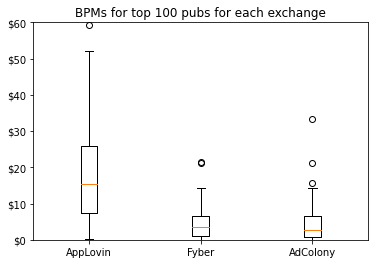

In [36]:
cols = ['bpm_AppLovin','bpm_AdColony','bpm_Fyber']
for x in ['AppLovin','Fyber','AdColony']:
    pub_dict[x].sort_values('cost', ascending = False, inplace = True)
    plt.boxplot(pub_dict[x].iloc[:100,9], positions = [['AppLovin','Fyber','AdColony'].index(x)-1])
    
plt.xticks([-1,0,1],['AppLovin','Fyber','AdColony'])
plt.ylim(0,60)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.title('BPMs for top 100 pubs for each exchange')

In [37]:
adcolony_applovin_fyber[adcolony_applovin_fyber.imp_overlap == 'Fyber/AdColony/AppLovin']

auctions_AppLovin  bids_AppLovin  \
hosting_bnd                                                         
1078160821                                 81344.0        81344.0   
1143516053                                388160.0        54848.0   
1206967173                             414440480.0         8224.0   
1207472156                             375738240.0      2134400.0   
1212951043                               1061152.0      1061152.0   
...                                            ...            ...   
word.cross.game.wordcrossy.free            71712.0         8736.0   
www.huolala.truckemall                   2659040.0      1632480.0   
www.stunt.stuntcarjumping                2019872.0      1205792.0   
www.wheelroad.wheeloffroad               2730272.0      1657120.0   
zombie.survival.dead.shooting           18503200.0       228896.0   

                                 impressions_AppLovin  win_rate_AppLovin  \
hosting_bnd                                                                
1078160821                                        8.0           0.009835   
1143516053                                       12.0           0.021879   
1206967173                                     5252.0          63.861868   
1207472156                                     1872.0           0.087706   
1212951043                                     3576.0           0.336992   
...                                               ...                ...   
word.cross.game.wordcrossy.free                 192.0           2.197802   
www.huolala.truckemall                         8624.0           0.528276   
www.stunt.stuntcarjumping                      8920.0           0.739763   
www.wheelroad.wheeloffroad                     8432.0           0.508835   
zombie.survival.dead.shooting                 42820.0          18.707186   

                                 clicks_AppLovin  ctr_AppLovin  \
hosting_bnd                                                      
1078160821                                   0.0      0.000000   
1143516053                                   8.0     66.666667   
1206967173                                1040.0     19.801980   
1207472156                                 388.0     20.726496   
1212951043                                 668.0     18.680089   
...                                          ...           ...   
word.cross.game.wordcrossy.free             20.0     10.416667   
www.huolala.truckemall                    2780.0     32.235622   
www.stunt.stuntcarjumping                 2252.0     25.246637   
www.wheelroad.wheeloffroad                2500.0     29.648956   
zombie.survival.dead.shooting            10116.0     23.624475   

                                 installs_AppLovin  ir_AppLovin  \
hosting_bnd                                                       
1078160821                                     0.0          NaN   
1143516053                                     0.0     0.000000   
1206967173                                     0.0     0.000000   
1207472156                                     0.0     0.000000   
1212951043                                     0.0     0.000000   
...                                            ...          ...   
word.cross.game.wordcrossy.free                0.0     0.000000   
www.huolala.truckemall                       440.0    15.827338   
www.stunt.stuntcarjumping                    412.0    18.294849   
www.wheelroad.wheeloffroad                   476.0    19.040000   
zombie.survival.dead.shooting                680.0     6.722025   

                                 uninstall_rate_AppLovin  ipm_AppLovin  ...  \
hosting_bnd                                                             ...   
1078160821                                           NaN      0.000000  ...   
1143516053                                           NaN      0.000000  ...   
1206967173                                           NaN      0.000000  ...   
1207472156          

In [38]:
type_pivot = pd.concat([type_dict['AppLovin'], type_dict['Fyber'], type_dict['AdColony']], keys = ['AppLovin','Fyber','AdColony'], names = ['exchange'])
type_pivot.iloc[:,1:].style.format(format_map).background_gradient(cmap=cm, subset = ['ctr','ir','uninstall_rate','ipm','cpm','revenue_sov','cost_sov','margin'])